# Import and loading

In [ ]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD, IncrementalPCA, TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import prince
import numpy as np

In [2]:
data = Loader.load_by_fueltype("Combustion")

c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[co

# Functions

In [3]:
def drop_columns_full_nan(data: pd.DataFrame) -> pd.DataFrame:
    #Remove the column that only contain NAs
    cols_to_drop = data.columns[data.isna().all()]
    data = data.drop(cols_to_drop, axis=1)
    return data

def get_combustion_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])

    #if all the values of the numerical columns is 0, we rem['Combustion']ove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)
    return numerical_columns

def fill_combustion_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    cols_mode = ['displacement_liters','doors','seatingCapacity','number_of_cylinders','cubicCapacity',"dimensions.length","dimensions.height","Llantas_Diametro_cm","number_of_cylinders","bore_diameter","stroke_length"]
    #fill the elemental columns that has a minor amount of missing data with the mode
    for col in cols_mode:
        numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, col)

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_torque")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_power")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Select and print only the categorical columns
    ret = df.select_dtypes(include=['category'])
    
    # Temporarily convert the column to strings to perform the replacement
    ret['traction'] = ret['traction'].astype(str).replace({"trasera": "trasero", "delantera": "delantero"})
    # Convert back to a categorical type
    ret['traction'] = ret['traction'].astype('category')

    
    # Remove redundant columns if this function is defined
    ret = Data_processor.remove_redundand_columns(ret)
    return ret


def fill_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    mode_cols = ['brakes','version','jato_classification']
    for col in mode_cols:
        df = Data_processor.fill_na_with_mode(df, col)
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model"] , Y="environmentalLabel")
    return df

def category_convert(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_convert = df.select_dtypes(include=['object']).columns
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    return df


# Column filters

In [4]:
# Quit all electric columns from data['Combustion']
for column in data.columns:
    if column.startswith('electric'):
        data = data.drop(columns=column)

In [5]:
# convert object columns to category
data = category_convert(data)

categorical_columns = get_combustion_categorical_columns(data)

categorical_columns = fill_combustion_categorical_columns(categorical_columns)

# Check amount of missing values
missing_values = categorical_columns.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values)
categorical_columns.head()
categorical_columns.columns
#categorical_columns['traction']

Series([], dtype: int64)


Index(['color', 'brand', 'model', 'version', 'fuelType', 'bodyTypeId',
       'transmissionTypeId', 'province', 'environmentalLabel',
       'jato_classification', 'traction', 'brakes', 'front_suspension',
       'rear_suspension', 'Acabado Exterior_Alerón',
       'Acabado Exterior_Cristales', 'Acabado Exterior_Faldones',
       'Acabado Exterior_Pintura', 'Acabado Exterior_Rueda', 'AC_Zones',
       'AC_Type', 'Metodo_Apertura', 'Tipo_Faro', 'interior_clock',
       'arm_suppport_front', 'arm_suppport_back', 'price_categ'],
      dtype='object')

In [6]:
# Drop all na columns 
data = drop_columns_full_nan(data)

numerical_columns = get_combustion_numerical_columns(data)


# fill the missing data in numerical columns
numerical_columns = fill_combustion_numerical_columns(numerical_columns)

# Check amount of missing values
missing_values_num = numerical_columns.isnull().sum()
missing_values_num = missing_values_num[missing_values_num > 0]

data[numerical_columns.columns] = numerical_columns

#correlation_matrix = numerical_columns.corr()
#correlation_matrix = correlation_matrix.sort_values(by='price', ascending=False)
print(missing_values_num)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6154091221985554%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 17.70914536272189%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 6.410215656255401%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 7.903819131160218%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 6.824540773438649%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 2.55180902596012e+16%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_torque: 67.97560330482807%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_power: 20.028480167086347%
Series([], dtype: int64)


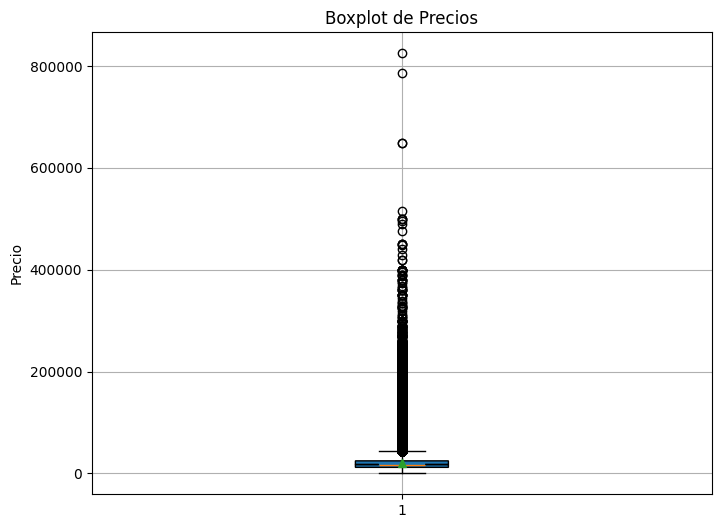

In [7]:
precios_combustion = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_combustion, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

Even though there seems to be many outliers in the data, after a manual inspection, it was found that the data is correct and the outliers are valid data points. (Most of them are from luxury brands such as Lamborghini, Ferrari, etc.)

In [8]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)[:10]

43901.5


,price,brand
idx,,
48458,825000,MERCEDES-BENZ
38166,786500,FERRARI
16685,648500,FERRARI
18873,648500,FERRARI
119510,515000,PORSCHE
16086,499900,FERRARI
78396,499900,LAMBORGHINI
76218,499900,LAMBORGHINI
19151,495000,LAMBORGHINI


# PCA

In [9]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [10]:
principal_components

array([[-0.94936538, -1.95424871],
       [-0.09526035, -0.50605691],
       [12.15540408,  3.56908054],
       ...,
       [-0.97962288, -0.29182012],
       [-3.21372284,  2.53701734],
       [-4.00545634, -1.52924421]])

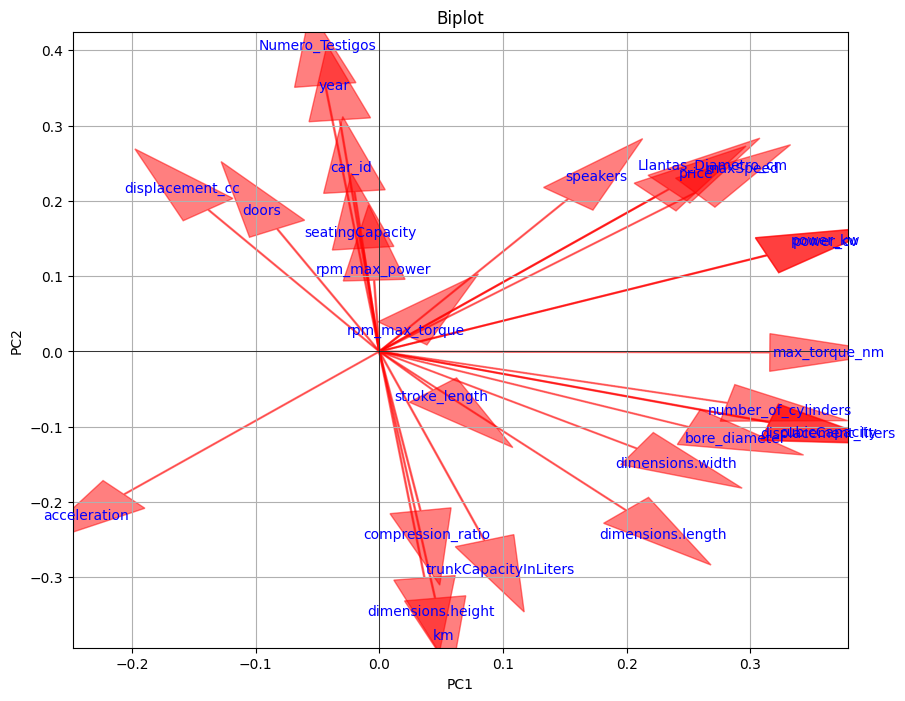

In [11]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

# Test CART regression trees with only numerical variables

In [12]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]

# Since too many features + rows are present, we will use PCA to reduce the dimensionality
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Check PCA-transformed data
print(f"Original shape: {X.shape}, Transformed shape: {X_pca.shape}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

Original shape: (129204, 26), Transformed shape: (129204, 17)


DecisionTreeRegressor(random_state=42)

MAE: 2275.2995339521353 
 MSE: 57882217.11892269 
 RMSE: 7608.036351051609 
 R2: 0.8693807758805843 
 MAPE: 12.033195862303094
Mean: 2275.2995339521353
Variance: 52705229.14971987
Standard Deviation: 7259.836716464074


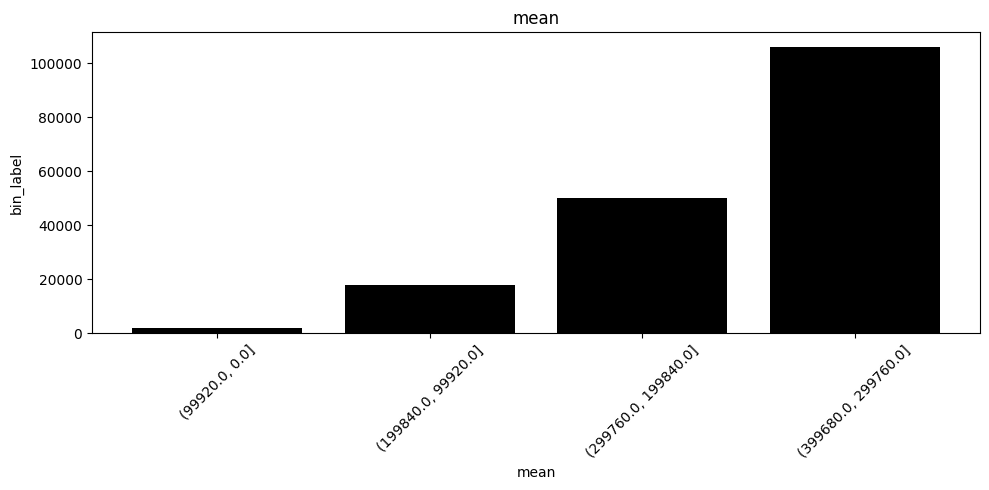

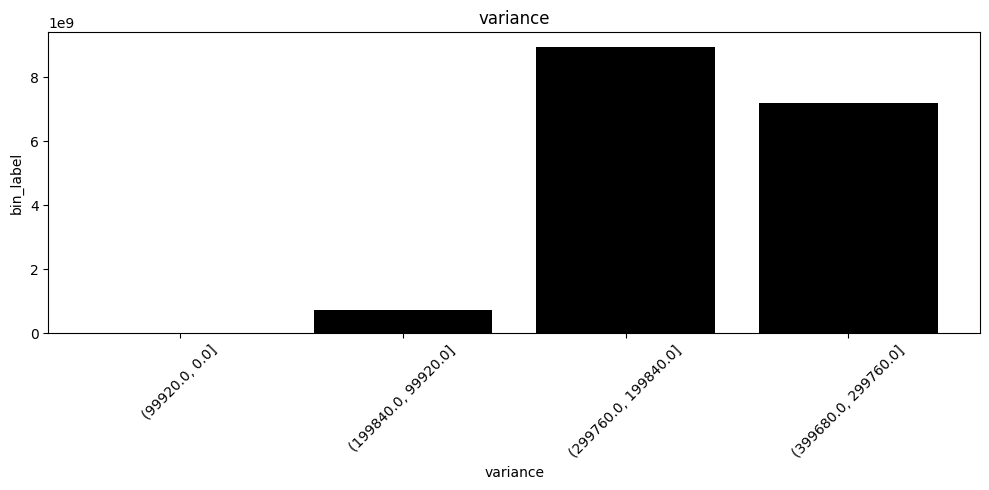

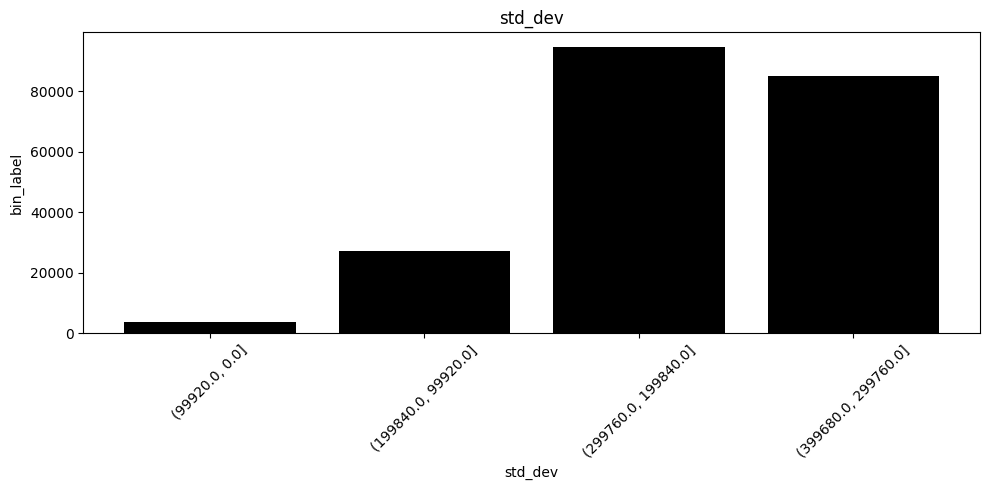

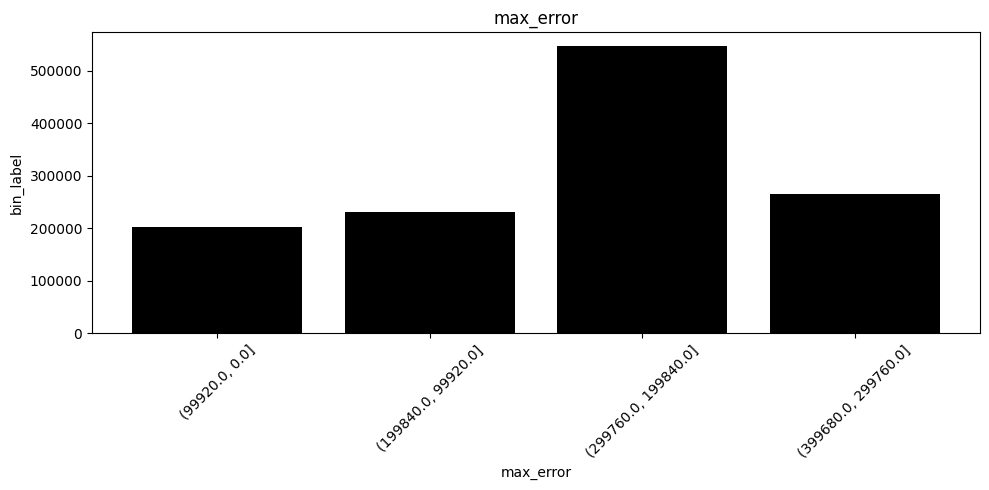

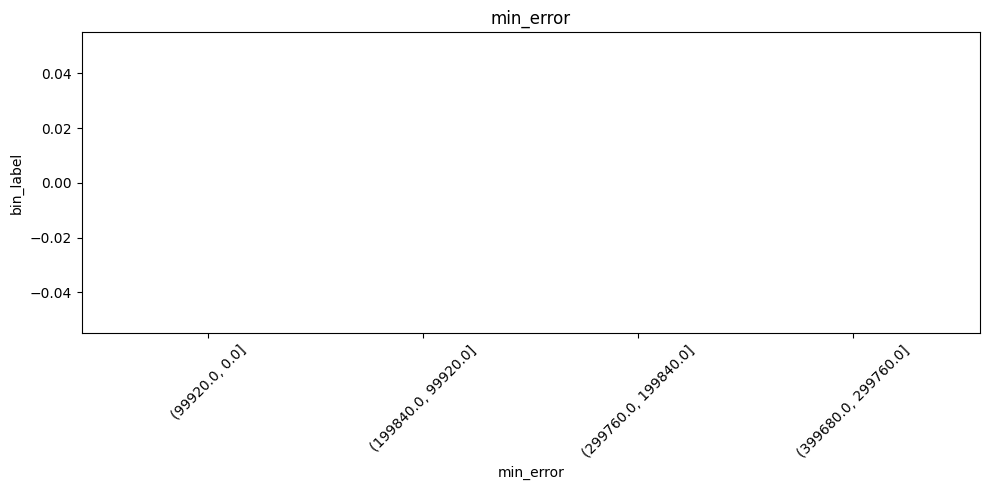

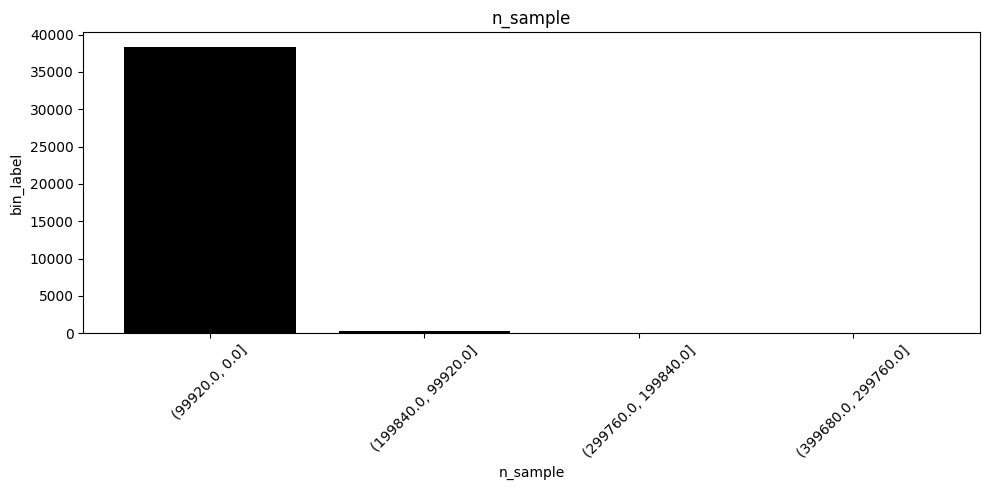

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(99920.0, 0.0]",2010.565162,1.425405e+07,3775.453800,203000.0,0.0,38374
1,"(199840.0, 99920.0]",17904.078125,7.468283e+08,27328.158704,230900.0,0.0,288
2,"(299760.0, 199840.0]",49946.071429,8.958611e+09,94649.937944,546500.0,0.0,77
3,"(399680.0, 299760.0]",106106.312500,7.197967e+09,84840.833685,266000.0,0.0,16


In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test)

# CA

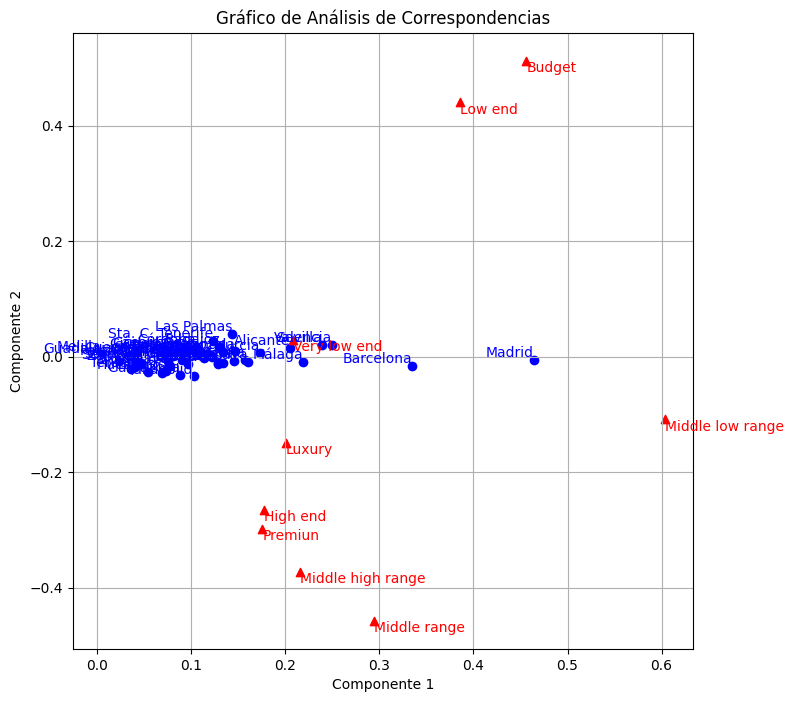

In [14]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [15]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     47015
Budget               26867
Low end              19272
Middle range         11219
Middle high range     6014
Very low end          5609
Luxury                5182
High end              4049
Premiun               3977
Name: count, dtype: int64

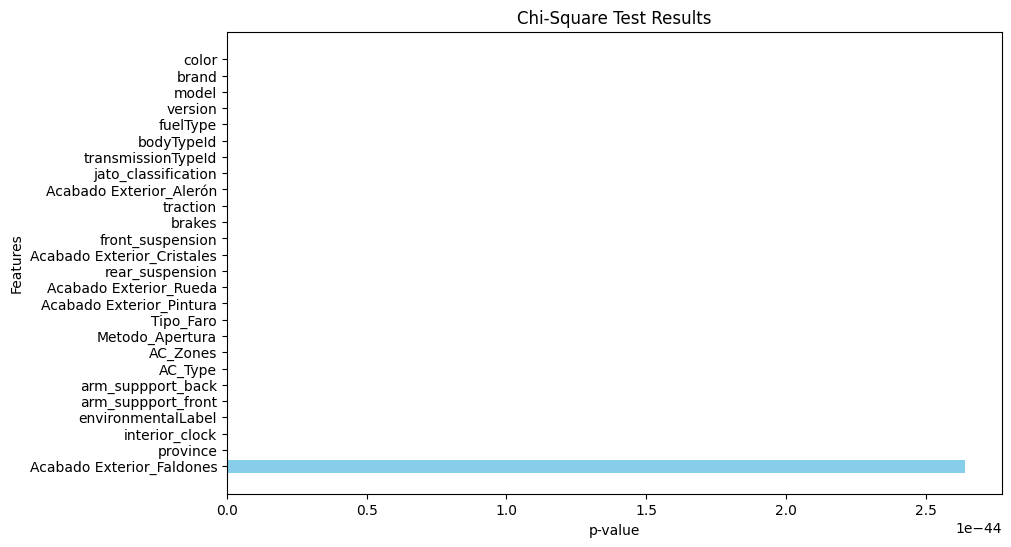

Index(['color', 'brand', 'model', 'version', 'fuelType', 'bodyTypeId',
       'transmissionTypeId', 'jato_classification', 'Acabado Exterior_Alerón',
       'traction', 'brakes', 'front_suspension', 'Acabado Exterior_Cristales',
       'rear_suspension', 'Acabado Exterior_Rueda', 'Acabado Exterior_Pintura',
       'Tipo_Faro', 'Metodo_Apertura', 'AC_Zones', 'AC_Type',
       'arm_suppport_back', 'arm_suppport_front', 'price_categ'],
      dtype='object')

In [16]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

# Categorical

## Test CART tree classifier with only categorical values

In [17]:
features_df = pd.get_dummies(categorical_columns.drop('price_categ', axis=1))

# Your target variable
target = categorical_columns['price_categ'].apply(Loader.encode_price_categ)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = cart_model.predict(X_test)

In [18]:
result = pd.DataFrame({"Real_Categorie": y_test, "Prediction": y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
idx,,,
35700,Budget,Budget,0
157809,Budget,Budget,0
46442,Low end,Low end,0
164823,Budget,Budget,0
104592,Budget,Budget,0
...,...,...,...
76424,Middle low range,Middle low range,0
148454,Middle low range,Middle low range,0
72048,Luxury,High end,2


In [19]:
# Calcular la precisión
Evaluator.eval_classfication(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.7073164439399412 
 Precision: 0.7041710782742121 
 Recall: 0.7073164439399412 
 F1 Score: 0.7054595466776329
Confusion Matrix:
 [[11637    35   114     6   109  1461   689    24    12]
 [   75   520     2    31   291     3   148   196     0]
 [  128     1  4052     3     3  1076     4     2   476]
 [   14    35     3  1276    17     3     9   194     2]
 [  199   216     2     9   804     7   467    57     1]
 [ 1336     2  1227     0     3  5512    17     2    29]
 [ 1117    82    10     8   343    20  1805    31     2]
 [   29   191     2   131    83     4    57   641     1]
 [   14     0   450     0     2    27     0     1  1170]]


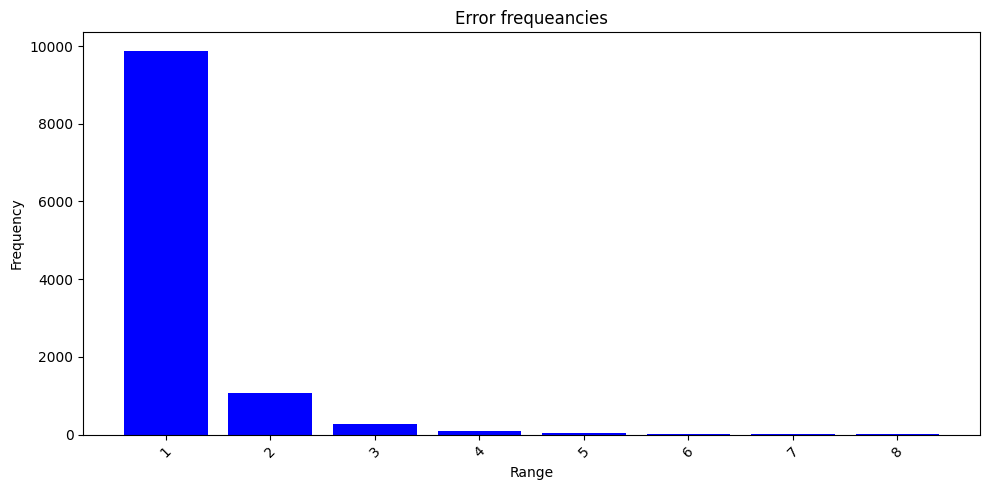

{np.int64(1): np.int64(9861), np.int64(2): np.int64(1079), np.int64(3): np.int64(274), np.int64(4): np.int64(82), np.int64(5): np.int64(32), np.int64(6): np.int64(7), np.int64(7): np.int64(8), np.int64(8): np.int64(2)}
Error mean: 1.1849272807404143
Error rate: 29.26835560600588 %
Overall mean: 0.3468087301996801


In [20]:
Evaluator.eval_ordinal_classification (result["diff"])

Even though the accuracy is only about 70% the errors are not a concern as many of the errors are of degree 1 (the guess was not far off)

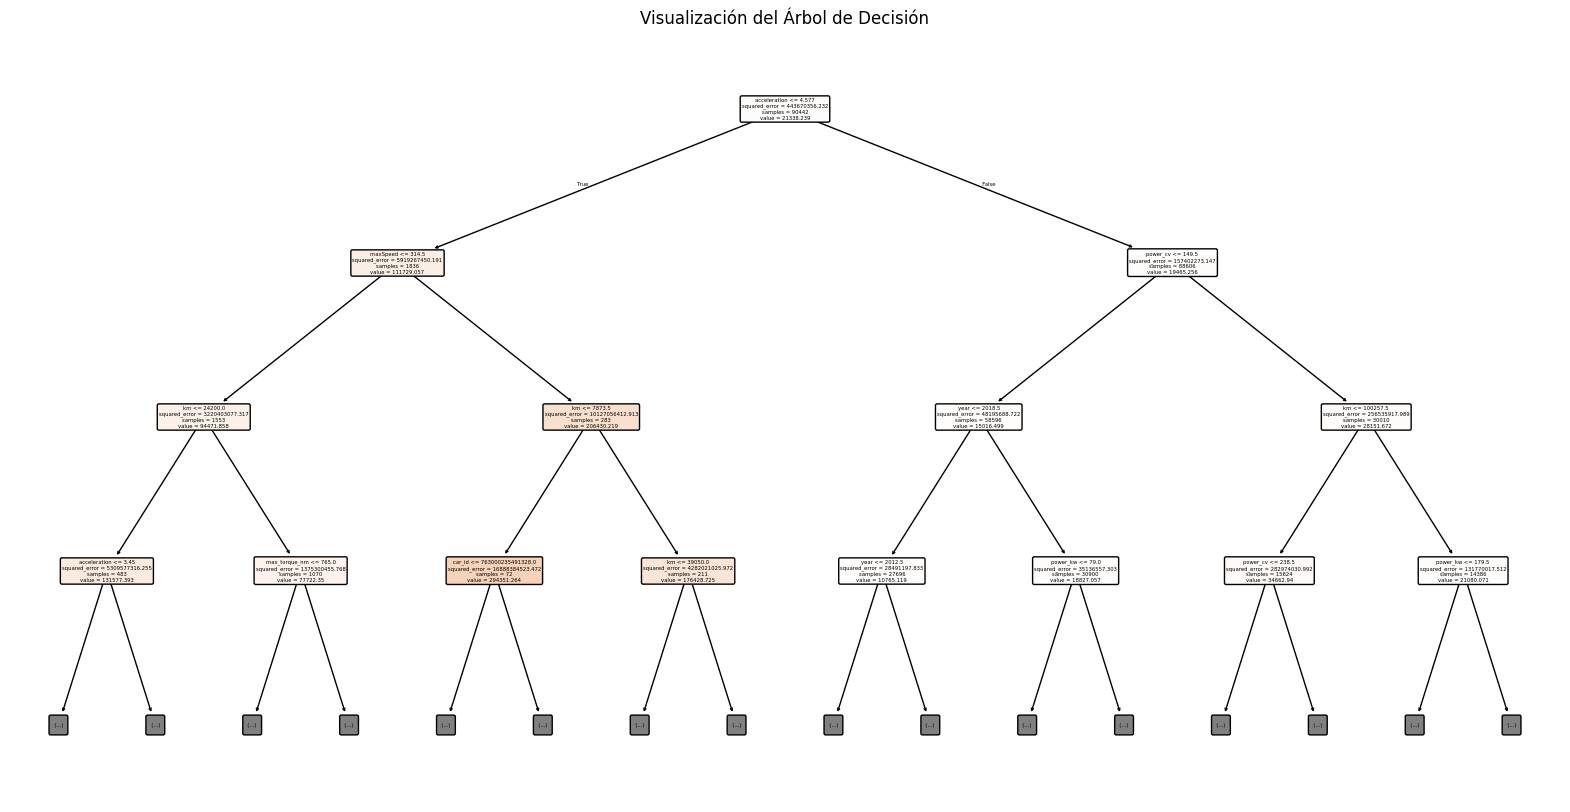

In [21]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

In [54]:
# Merge numerical and categorical columns
combustion_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how="inner")
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

# Separate target variables
target = combustion_cars[["price", "price_categ"]]
combustion_cars.drop(columns=["price", "price_categ"], inplace=True)

# Update feature lists by removing targets
numerical_column_names.remove("price")
categorical_column_names.remove("price_categ")

# Initialize dictionary to store encoders/scalers
encoders_and_scalers = {}

# Scale and apply PCA to numerical columns
numerical_data = combustion_cars[numerical_column_names]
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Apply IncrementalPCA to numerical data
incremental_pca_numerical = PCA(n_components=0.95)
numerical_data_pca = incremental_pca_numerical.fit_transform(numerical_data_scaled)

# Store the scaler and PCA for numerical columns
encoders_and_scalers["numerical_scaler"] = scaler
encoders_and_scalers["numerical_pca"] = incremental_pca_numerical

# Encode categorical columns (sparse matrix)
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
categorical_data_encoded = encoder.fit_transform(combustion_cars[categorical_column_names])

# Instead of PCA on categorical data, use TruncatedSVD for sparse matrix
svd_categorical = TruncatedSVD(n_components=30)
categorical_data_svd = svd_categorical.fit_transform(categorical_data_encoded)

# Store the encoder and SVD for categorical columns
encoders_and_scalers["categorical_encoder"] = encoder
encoders_and_scalers["categorical_svd"] = svd_categorical

# Combine the PCA-transformed numerical and SVD-transformed categorical data
combustion_cars_encoded = pd.DataFrame(
    data=np.hstack([numerical_data_pca, categorical_data_svd]),
    index=combustion_cars.index
)

print("Shape after dimensionality reduction:")
print(combustion_cars_encoded.shape)




Shape after dimensionality reduction:
(129204, 47)


## Classification

In [30]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combustion_cars_encoded, target['price_categ'], test_size=0.3, random_state=42)

In [32]:
def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"].apply(Loader.encode_price_categ).to_numpy() - result["Prediction"].apply(Loader.encode_price_categ).to_numpy()
    Evaluator.eval_ordinal_classification(diff=result["diff"])

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier = classifier
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        return Evaluator.eval_classfication(y_pred = y_pred, y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    return Evaluator.eval_classfication(y_pred = y_pred, y_true=y_test, binary_classification=False)

## Cart

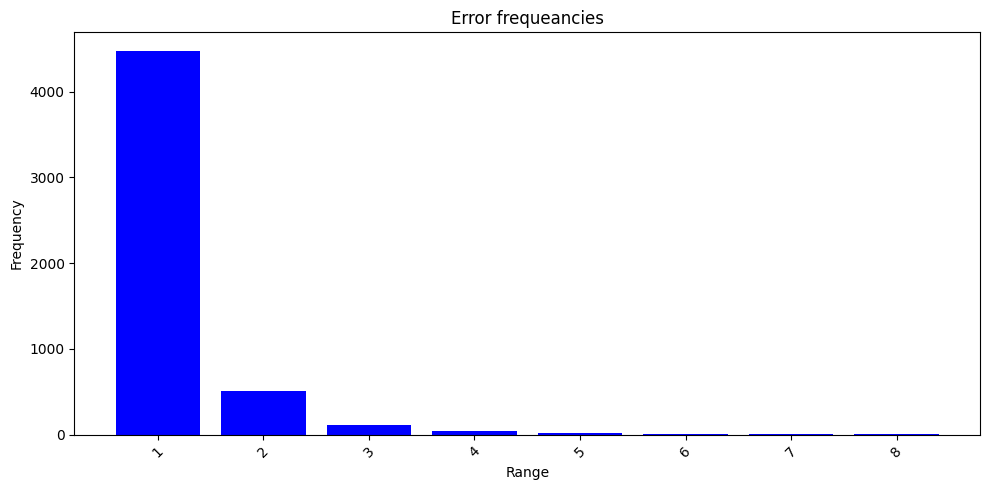

{np.int64(1): np.int64(4467), np.int64(2): np.int64(513), np.int64(3): np.int64(112), np.int64(4): np.int64(42), np.int64(5): np.int64(19), np.int64(6): np.int64(7), np.int64(7): np.int64(4), np.int64(8): np.int64(2)}
Error mean: 1.1958962446767325
Error rate: 13.327485681853362 %
Overall mean: -0.0036375832000412776
Accuracy: 0.7343016356225169 
 Precision: 0.7349631691961203 
 Recall: 0.7343016356225169 
 F1 Score: 0.7345977111122026
Confusion Matrix:
 [[ 5849    10   973     1    20  1191    39     6    39]
 [    1   652     3    29   243    44   109   184     1]
 [ 1029     5  4045     1     6   141    14     2   502]
 [    4    33     4  1319     9    13    16   153     2]
 [    5   261     5    22   929   112   371    57     0]
 [ 1262    57   134    11   137 11703   741    34     8]
 [   29    88    11    11   349   782  2103    42     3]
 [    3   181     2   131    57    17    35   713     0]
 [   39     0   460     2     1     6     4     2  1150]]


In [33]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42), classifier_name="CART")

## Random Forest

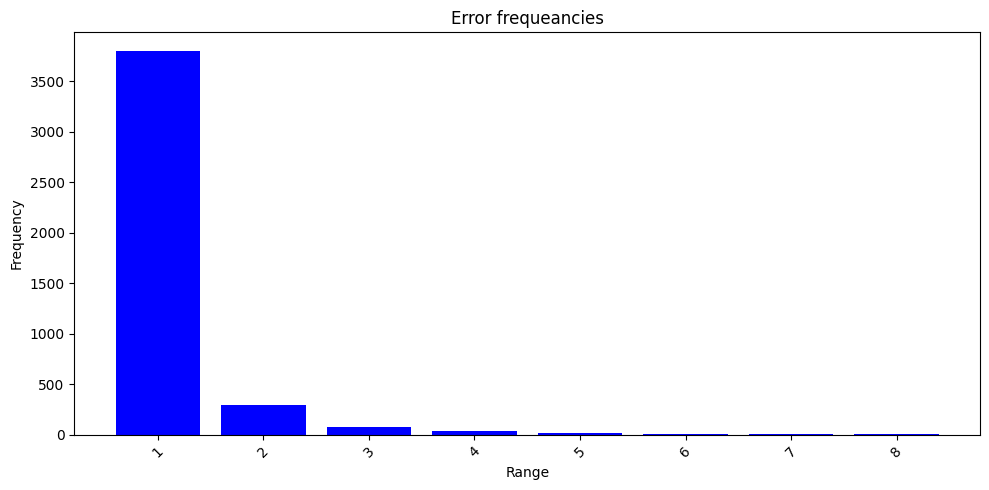

{np.int64(1): np.int64(3796), np.int64(2): np.int64(295), np.int64(3): np.int64(79), np.int64(4): np.int64(32), np.int64(5): np.int64(17), np.int64(6): np.int64(5), np.int64(7): np.int64(1), np.int64(8): np.int64(1)}
Error mean: 1.1549929010884998
Error rate: 10.902430215159177 %
Overall mean: 0.018058923688148185
Accuracy: 0.7915742221763583 
 Precision: 0.7879726677485901 
 Recall: 0.7915742221763583 
 F1 Score: 0.7890291794649891
Confusion Matrix:
 [[ 6332     2   731     0     1  1046     6     1     9]
 [    1   638     5    24   293    41    67   197     0]
 [  840     0  4590     0     2    54     1     0   258]
 [    2    17     1  1387     5    11     4   125     1]
 [    1   225     2     4   963   112   417    38     0]
 [  917    10    48     2    30 12664   405     5     6]
 [    5    41     8     2   277   917  2151    17     0]
 [    1   138     3   139    37    25    18   778     0]
 [   11     0   467     0     0     5     1     0  1180]]


In [34]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

## SVC (CUML IMPLEMENTATION WIP)

## Naive Bayes

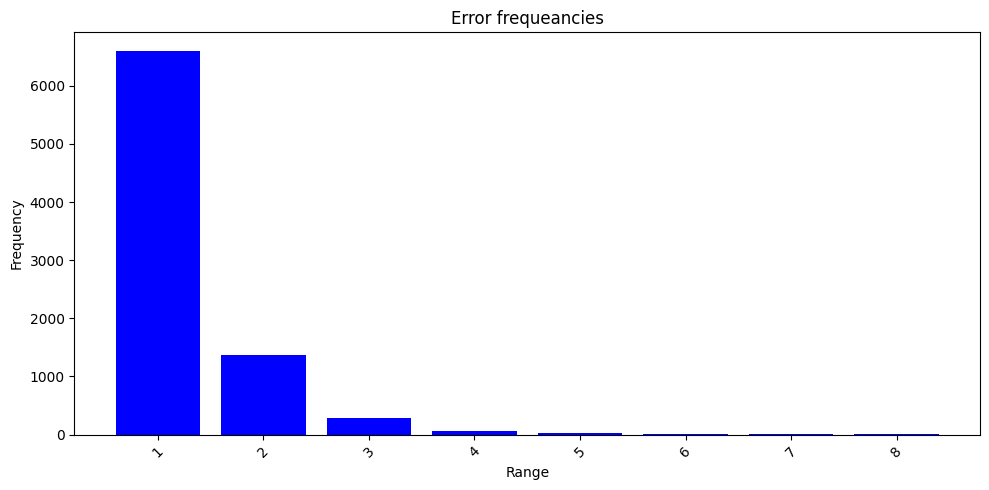

{np.int64(1): np.int64(6589), np.int64(2): np.int64(1369), np.int64(3): np.int64(279), np.int64(4): np.int64(57), np.int64(5): np.int64(23), np.int64(6): np.int64(8), np.int64(7): np.int64(3), np.int64(8): np.int64(3)}
Error mean: 1.2723562597527307
Error rate: 21.492699035137505 %
Overall mean: -0.1421753263505495
Accuracy: 0.5314999226046128 
 Precision: 0.5357391730611968 
 Recall: 0.5314999226046128 
 F1 Score: 0.5159946011629641
Confusion Matrix:
 [[ 4222    75   928    54    68  2508    29    94   150]
 [    0   170     4    75   523   110    22   357     5]
 [ 1976    23  2235    42    14   195    14    29  1217]
 [    2    65     2   894   100    18    16   453     3]
 [    2   160     6    57   755   477    40   264     1]
 [ 1599   310   222   117   974 10421    85   315    44]
 [   40   237    15    62  1035  1704    71   250     4]
 [    0   125     1   150   393    31     8   430     1]
 [   16     2   223     6     1     8     1     3  1404]]


In [35]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes") # GaussianNB seems to give the best results

## ANN

In [37]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(target[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    combustion_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5960 - loss: 1.0627 - val_accuracy: 0.7231 - val_loss: 0.6737
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.7397 - loss: 0.6401 - val_accuracy: 0.7437 - val_loss: 0.6290
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.7521 - loss: 0.6045 - val_accuracy: 0.7471 - val_loss: 0.6087
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - accuracy: 0.7637 - loss: 0.5777 - val_accuracy: 0.7533 - val_loss: 0.5972
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.7695 - loss: 0.5605 - val_accuracy: 0.7543 - val_loss: 0.5924
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - accuracy: 0.7735 - loss: 0.5529 - val_accuracy: 0.7533 - val_loss: 0.5920
Epoch 7/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.7769 - loss: 0.5410 - val_accuracy: 0.7601 - val_loss: 0.5782
Epoch 8/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.7823 - loss: 0.5

Before the dimensionality reduction, it has an accuracy of 0.90 and after is an accuracy of 0.87 which even though it is a 0.03 which is not low, the training time has reduced from 25 sec per epoch average to 1 sec per epoch which is quite considerable

In [38]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step


In [39]:
Evaluator.eval_classfication(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

Accuracy: 0.7701872968371085 
 Precision: 0.7682309364633135 
 Recall: 0.7701872968371085 
 F1 Score: 0.7688832265874492
Confusion Matrix:
 [[ 6161     2   862     0     6  1078     8     0    11]
 [    4   605     1    15   354    33    66   188     0]
 [  874     0  4424     1     0    56     5     1   384]
 [    4    22     2  1371     3     6     4   141     0]
 [    3   234     0     8  1020    69   392    36     0]
 [ 1171     9    27     2    63 12266   537     5     7]
 [    3    60     5     6   384   924  2018    15     3]
 [    2   192     0   146    48    12    18   721     0]
 [    9     0   379     0     0     6     2     0  1268]]


## Regression

In [40]:
X_train, X_test, y_train, y_test = train_test_split(combustion_cars_encoded, target['price'], test_size=0.3, random_state=42)

In [41]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor = regressor
    regressor.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = regressor.predict(X_test)
    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name=regressor_name)
    Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)

### Cart

In [42]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

MAE: 2602.0514648407907 
 MSE: 60489225.1029359 
 RMSE: 7777.48192559365 
 R2: 0.8634977019920134 
 MAPE: 14.145680117606696
Mean: 2602.0514648407907
Variance: 53718553.277255796
Standard Deviation: 7329.294186840626
r2_adjusted: 0.8633319839570293
MAE: 2602.0514648407907 
 MSE: 60489225.1029359 
 RMSE: 7777.48192559365 
 R2: 0.8634977019920134 
 MAPE: 14.145680117606696
Mean: 2602.0514648407907
Variance: 53718553.277255796
Standard Deviation: 7329.294186840626


### Random Forest

In [43]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

MAE: 1971.1162543762193 
 MSE: 29999682.549472295 
 RMSE: 5477.196595839179 
 R2: 0.9323015694027413 
 MAPE: 10.839974213247679
Mean: 1971.1162543762193
Variance: 26114383.261206158
Standard Deviation: 5110.2234061933295
r2_adjusted: 0.9322193814025845
MAE: 1971.1162543762193 
 MSE: 29999682.549472295 
 RMSE: 5477.196595839179 
 R2: 0.9323015694027413 
 MAPE: 10.839974213247679
Mean: 1971.1162543762193
Variance: 26114383.261206158
Standard Deviation: 5110.2234061933295


### SVM Regression (WIP)

In [ ]:
#regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'), regressor_name="SVR")

### Multivariable Regression

In [44]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

Coefficients: [ 4458.90438746 -4661.54071442  1863.15530697 -3697.60402304
  -615.01942044 -1025.93429984    93.52775858 -1146.75886507
  2544.30958551 -2361.06358237  2436.59498141  -378.13959465
   401.51899489 -2115.49735922 -1553.87139711  2148.59346463
   786.89207125 -2378.19963211 -1240.06487761  -300.36053083
  2598.61676798   -58.30342062  -163.6318927   -784.80533378
 -1017.42275834  -996.86409207   495.26477283  -199.42623121
   -81.14749402 -1204.02850117   488.84750505  -321.16230873
  1556.71201517  1230.61351907  1139.96521163   139.55157617
  -610.40427536  -760.35262823 -3975.86223528  1730.16813136
  1011.57336765  3002.29381058   846.26943702   723.73301202
   506.88311231 -2087.64130615  2389.39103453]
Intercept: 28417.057826947366


In [45]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

## ANN

### Regression

In [46]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [48]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - loss: 493844960.0000 - mae: 12818.8926 - val_loss: 112746024.0000 - val_mae: 4404.1187
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - loss: 112762392.0000 - mae: 4228.7402 - val_loss: 89767016.0000 - val_mae: 3936.5396
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - loss: 86021576.0000 - mae: 3756.9451 - val_loss: 71217816.0000 - val_mae: 3478.0752
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - loss: 74204408.0000 - mae: 3413.7327 - val_loss: 59662492.0000 - val_mae: 3235.8562
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - loss: 53728756.0000 - mae: 3189.2949 - val_loss: 52948372.0000 - val_mae: 3045.6738
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - loss: 60421408.0000 - mae: 3057.7942 - val_loss: 50000040.0000 - val_mae: 2981.7070
Epoch 7/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - loss: 47685168.0000 - mae: 2918.1990 - val_loss: 47660188.0000 - val_mae: 2908.5413
Epoch 8/1

In [49]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

1212/1212 - 0s - 405us/step - loss: 29284130.0000 - mae: 2219.5564
Mean Absolute Error on test set: 2219.56


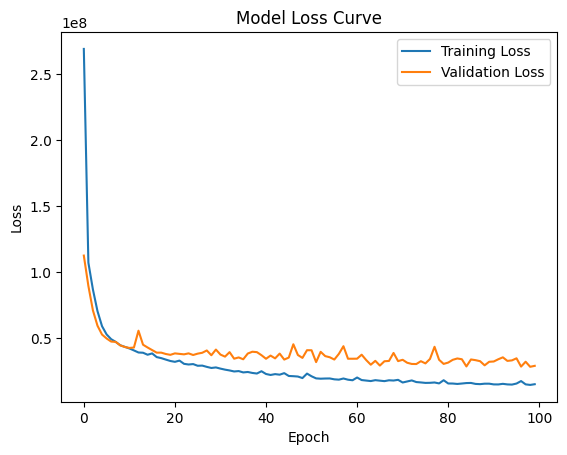

In [50]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [51]:
y_pred = model.predict(X_test).flatten()

1212/1212 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step


In [52]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="ANN")

MAE: 2219.556655927091 
 MSE: 29284144.507413846 
 RMSE: 5411.482653341304 
 R2: 0.9339162707328796 
 MAPE: 12.157174721284182
Mean: 2219.556655927091
Variance: 24357712.758543592
Standard Deviation: 4935.353357009363
r2_adjusted: 0.9338360430303546


,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(99920.0, 0.0]",1996.029291,7.032681e+06,2651.920178,143345.609375,0.014893,38374
1,"(199840.0, 99920.0]",16297.424540,2.961868e+08,17210.078111,142295.312500,116.343750,288
2,"(299760.0, 199840.0]",36813.353427,1.967128e+09,44352.314869,279702.963867,301.359375,77
3,"(399680.0, 299760.0]",90966.207520,5.734020e+09,75723.311606,281442.945312,963.125000,16


In [53]:
Evaluator.save("combustion")

Regression results saved to: evaluation/combustion_regression.tex
Classification results saved to: evaluation/combustion_classification.tex
